In [1]:
%pip install opencv-python numpy matplotlib pillow ipywidgets


   ---------------------------------------- 0.0/914.9 kB ? eta -:--:--
   ---------------------------------------- 0.0/914.9 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/914.9 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/914.9 kB ? eta -:--:--
   --------------------- ---------------- 524.3/914.9 kB 621.2 kB/s eta 0:00:01
   --------------------- ---------------- 524.3/914.9 kB 621.2 kB/s eta 0:00:01
   --------------------- ---------------- 524.3/914.9 kB 621.2 kB/s eta 0:00:01
   ---------------------------------------- 914.9/914.9 kB 696.7 kB/s  0:00:01
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.2 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.2 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.2 MB ? eta -:--:--
   --------- ------------------------------ 0.5/

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io
import os
from pathlib import Path
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
import time

# Setup for Jupyter display
%matplotlib inline

print("🎯 DOCUMENT AUTO-CROPPER")
print("📤 Upload an image → Get auto-cropped result")
print("=" * 50)

🎯 DOCUMENT AUTO-CROPPER
📤 Upload an image → Get auto-cropped result


In [8]:
# ==============================================
# 📤 2. SIMPLE FILE UPLOAD FUNCTION
# ==============================================

def upload_and_process():
    """Simple upload function using PIL"""
    from IPython.display import display, Javascript, clear_output
    
    # JavaScript to trigger file input
    display(Javascript('''
        // Create file input
        const input = document.createElement('input');
        input.type = 'file';
        input.accept = '.png,.jpg,.jpeg,.bmp,.tiff';
        input.style.display = 'none';
        
        // Add to page
        document.body.appendChild(input);
        
        // Trigger click
        input.click();
        
        // Handle file selection
        input.onchange = function(e) {
            const file = e.target.files[0];
            const reader = new FileReader();
            
            reader.onload = function(event) {
                // Send file data to Python
                const data = event.target.result.split(',')[1];
                IPython.notebook.kernel.execute(`process_uploaded_file('${data}', '${file.name}')`);
            };
            
            reader.readAsDataURL(file);
        };
    '''))
    
    print("📤 Select an image file from the dialog that appears...")

# Create the upload function
upload_and_process()

<IPython.core.display.Javascript object>

📤 Select an image file from the dialog that appears...


In [18]:

import base64
from PIL import Image
import io
import cv2
import numpy as np

def base64_to_image(base64_string, filename):
    """Convert base64 string to OpenCV image"""
    try:
        # Decode base64
        image_data = base64.b64decode(base64_string)
        
        # Convert to PIL Image
        pil_image = Image.open(io.BytesIO(image_data))
        
        # Convert to OpenCV format
        opencv_image = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)
        
        return opencv_image, filename
    except Exception as e:
        print(f"Error converting base64 to image: {e}")
        return None, filename

def preprocess_image(img):
    """Prepare image for contour detection"""
    if img is None:
        return None, None
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Edge detection
    edges = cv2.Canny(blurred, 50, 150)
    
    # Dilate to connect edges
    kernel = np.ones((5, 5), np.uint8)
    edges = cv2.dilate(edges, kernel, iterations=1)
    
    return edges, gray

def find_document_contour(edges):
    """Find the main document contour"""
    if edges is None:
        return None
    
    # Find all contours
    contours, _ = cv2.findContours(
        edges.copy(), 
        cv2.RETR_EXTERNAL, 
        cv2.CHAIN_APPROX_SIMPLE
    )
    
    if not contours:
        return None
    
    # Sort by area (largest first)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    
    # Check top 5 contours
    for contour in contours[:5]:
        # Approximate the contour
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        
        # If it has 4 points, it's likely a document
        if len(approx) == 4:
            return approx
    
    # If no 4-point contour, use bounding box
    if contours:
        x, y, w, h = cv2.boundingRect(contours[0])
        return np.array([[x, y], [x+w, y], [x+w, y+h], [x, y+h]])
    
    return None

def order_corners(pts):
    """Order points: TL, TR, BR, BL"""
    if pts is None or len(pts) != 4:
        return None
    
    rect = np.zeros((4, 2), dtype="float32")
    
    # Sum of coordinates
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]  # Top-left
    rect[2] = pts[np.argmax(s)]  # Bottom-right
    
    # Difference of coordinates
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]  # Top-right
    rect[3] = pts[np.argmax(diff)]  # Bottom-left
    
    return rect

def perspective_transform(image, contour):
    """Apply perspective correction"""
    if image is None:
        return None
        
    if contour is None or len(contour) != 4:
        return image
    
    # Order the points
    rect = order_corners(contour.reshape(4, 2))
    if rect is None:
        return image
    
    (tl, tr, br, bl) = rect
    
    # Calculate dimensions
    width_top = np.linalg.norm(tr - tl)
    width_bottom = np.linalg.norm(br - bl)
    max_width = max(int(width_top), int(width_bottom))
    
    height_left = np.linalg.norm(bl - tl)
    height_right = np.linalg.norm(br - tr)
    max_height = max(int(height_left), int(height_right))
    
    # Destination points
    dst = np.array([
        [0, 0],
        [max_width - 1, 0],
        [max_width - 1, max_height - 1],
        [0, max_height - 1]
    ], dtype="float32")
    
    # Perspective transform
    matrix = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, matrix, (max_width, max_height))
    
    return warped

def save_results(original, cropped, filename):
    """Save results to file"""
    if original is None or cropped is None:
        print("Cannot save: No image data")
        return None, None
    
    # Create output directory
    output_dir = Path("auto_crop_results")
    output_dir.mkdir(exist_ok=True)
    
    # Generate timestamp
    timestamp = int(time.time())
    name_without_ext = Path(filename).stem
    
    # Save files
    orig_path = output_dir / f"{name_without_ext}_original_{timestamp}.jpg"
    crop_path = output_dir / f"{name_without_ext}_cropped_{timestamp}.jpg"
    
    try:
        cv2.imwrite(str(orig_path), original)
        cv2.imwrite(str(crop_path), cropped)
        
        print(f"✅ Files saved successfully!")
        return str(orig_path), str(crop_path)
    except Exception as e:
        print(f"❌ Error saving files: {e}")
        return None, None

print("✅ Image processing functions loaded successfully!")

✅ Image processing functions loaded successfully!


In [21]:
# ==============================================
# 🎨 4. DISPLAY & SAVE FUNCTIONS
# ==============================================

def display_results(original, cropped, contour=None):
    """Display before/after comparison"""
    if original is None or cropped is None:
        print("❌ Cannot display: No image data")
        return
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Convert BGR to RGB for display
    original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    
    # Draw contour on original if available
    if contour is not None:
        img_with_contour = original_rgb.copy()
        cv2.drawContours(img_with_contour, [contour], -1, (0, 255, 0), 3)
        axes[0].imshow(img_with_contour)
        axes[0].set_title('📷 Original with Document Outline')
    else:
        axes[0].imshow(original_rgb)
        axes[0].set_title('📷 Original Image')
    axes[0].axis('off')
    
    # Show edge detection (for understanding the process)
    edges, _ = preprocess_image(original)
    if edges is not None:
        axes[1].imshow(edges, cmap='gray')
        axes[1].set_title('🔍 Detected Edges')
    else:
        axes[1].text(0.5, 0.5, 'No edges detected', 
                    horizontalalignment='center', verticalalignment='center')
    axes[1].axis('off')
    
    # Show cropped result
    cropped_rgb = cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB)
    axes[2].imshow(cropped_rgb)
    axes[2].set_title('✂️ Auto-Cropped Result')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

def save_cropped_results(original, cropped, filename):
    """Save original and cropped images"""
    if original is None or cropped is None:
        print("❌ Cannot save: No image data")
        return None, None
    
    try:
        # Create output directory
        output_dir = Path("cropped_results")
        output_dir.mkdir(exist_ok=True)
        
        # Get filename without extension
        name_without_ext = Path(filename).stem
        
        # Generate timestamp
        timestamp = int(time.time())
        
        # Save original image
        orig_path = output_dir / f"{name_without_ext}_original_{timestamp}.jpg"
        cv2.imwrite(str(orig_path), original)
        
        # Save cropped image
        crop_path = output_dir / f"{name_without_ext}_cropped_{timestamp}.jpg"
        cv2.imwrite(str(crop_path), cropped)
        
        print(f"✅ Files saved successfully!")
        print(f"   Original: {orig_path}")
        print(f"   Cropped: {crop_path}")
        
        return str(orig_path), str(crop_path)
        
    except Exception as e:
        print(f"❌ Error saving files: {e}")
        return None, None

def show_single_image(img, title="Image", figsize=(8, 6)):
    """Display a single image"""
    if img is None:
        print("No image to display")
        return
    
    plt.figure(figsize=figsize)
    
    # Convert BGR to RGB if needed
    if len(img.shape) == 3 and img.shape[2] == 3:
        img_display = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        img_display = img
    
    plt.imshow(img_display)
    plt.title(title)
    plt.axis('off')
    plt.show()

print("✅ Display and save functions loaded!")

✅ Display and save functions loaded!


In [22]:
# ==============================================
# 🧠 3. IMAGE PROCESSING FUNCTIONS (COMPLETE)
# ==============================================

import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io
import os
from pathlib import Path
import base64
import time

def load_image(file_path):
    """Load image from file path"""
    if not os.path.exists(file_path):
        print(f"❌ File not found: {file_path}")
        return None
    
    img = cv2.imread(file_path)
    if img is None:
        print(f"❌ Failed to read image: {file_path}")
        return None
    
    print(f"✅ Loaded: {file_path} ({img.shape[1]}x{img.shape[0]})")
    return img

def preprocess_image(img):
    """Prepare image for contour detection"""
    if img is None:
        print("❌ Cannot preprocess: No image")
        return None, None
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Edge detection
    edges = cv2.Canny(blurred, 50, 150)
    
    # Dilate to connect edges
    kernel = np.ones((5, 5), np.uint8)
    edges = cv2.dilate(edges, kernel, iterations=1)
    
    return edges, gray

def find_document_contour(edges):
    """Find the main document contour"""
    if edges is None:
        print("❌ Cannot find contour: No edges")
        return None
    
    # Find all contours
    contours, _ = cv2.findContours(
        edges.copy(), 
        cv2.RETR_EXTERNAL, 
        cv2.CHAIN_APPROX_SIMPLE
    )
    
    if not contours:
        print("⚠️ No contours found in image")
        return None
    
    print(f"✅ Found {len(contours)} contours")
    
    # Sort by area (largest first)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    
    # Check top 5 contours
    for i, contour in enumerate(contours[:5]):
        # Approximate the contour
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        
        # If it has 4 points, it's likely a document
        if len(approx) == 4:
            print(f"✅ Found quadrilateral contour (area: {cv2.contourArea(contour):.0f})")
            return approx
    
    # If no 4-point contour, use bounding box of largest contour
    if contours:
        x, y, w, h = cv2.boundingRect(contours[0])
        print(f"⚠️ No perfect document found. Using bounding box.")
        return np.array([[x, y], [x+w, y], [x+w, y+h], [x, y+h]])
    
    return None

def order_corners(pts):
    """Order points: TL, TR, BR, BL"""
    if pts is None or len(pts) != 4:
        return None
    
    rect = np.zeros((4, 2), dtype="float32")
    
    # Sum of coordinates
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]  # Top-left
    rect[2] = pts[np.argmax(s)]  # Bottom-right
    
    # Difference of coordinates
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]  # Top-right
    rect[3] = pts[np.argmax(diff)]  # Bottom-left
    
    return rect

def perspective_transform(image, contour):
    """Apply perspective correction"""
    if image is None:
        print("❌ Cannot transform: No image")
        return None
        
    if contour is None or len(contour) != 4:
        print("⚠️ Invalid contour. Returning original image.")
        return image
    
    # Order the points
    rect = order_corners(contour.reshape(4, 2))
    if rect is None:
        print("⚠️ Cannot order corners. Returning original.")
        return image
    
    (tl, tr, br, bl) = rect
    
    # Calculate dimensions
    width_top = np.linalg.norm(tr - tl)
    width_bottom = np.linalg.norm(br - bl)
    max_width = max(int(width_top), int(width_bottom))
    
    height_left = np.linalg.norm(bl - tl)
    height_right = np.linalg.norm(br - tr)
    max_height = max(int(height_left), int(height_right))
    
    # Destination points
    dst = np.array([
        [0, 0],
        [max_width - 1, 0],
        [max_width - 1, max_height - 1],
        [0, max_height - 1]
    ], dtype="float32")
    
    # Perspective transform
    matrix = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, matrix, (max_width, max_height))
    
    print(f"✅ Perspective correction applied: {max_width}x{max_height}")
    return warped

def save_results(original, cropped, filename):
    """Save results to file"""
    if original is None or cropped is None:
        print("❌ Cannot save: No image data")
        return None, None
    
    # Create output directory
    output_dir = Path("auto_crop_results")
    output_dir.mkdir(exist_ok=True)
    
    # Generate timestamp
    timestamp = int(time.time())
    name_without_ext = Path(filename).stem
    
    # Save files
    orig_path = output_dir / f"{name_without_ext}_original_{timestamp}.jpg"
    crop_path = output_dir / f"{name_without_ext}_cropped_{timestamp}.jpg"
    
    try:
        cv2.imwrite(str(orig_path), original)
        cv2.imwrite(str(crop_path), cropped)
        
        print(f"✅ Files saved successfully!")
        return str(orig_path), str(crop_path)
    except Exception as e:
        print(f"❌ Error saving files: {e}")
        return None, None

print("✅ All image processing functions loaded successfully!")
print("Available functions:")
print("  • load_image('path/to/image.jpg')")
print("  • preprocess_image(img)")
print("  • find_document_contour(edges)")
print("  • perspective_transform(img, contour)")

✅ All image processing functions loaded successfully!
Available functions:
  • load_image('path/to/image.jpg')
  • preprocess_image(img)
  • find_document_contour(edges)
  • perspective_transform(img, contour)


In [23]:
# ==============================================
# 🎨 4. DISPLAY & SAVE FUNCTIONS
# ==============================================

def display_results(original, cropped, contour=None):
    """Display before/after comparison"""
    if original is None or cropped is None:
        print("❌ Cannot display: No image data")
        return
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Convert BGR to RGB for display
    original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    
    # Draw contour on original if available
    if contour is not None:
        img_with_contour = original_rgb.copy()
        cv2.drawContours(img_with_contour, [contour], -1, (0, 255, 0), 3)
        axes[0].imshow(img_with_contour)
        axes[0].set_title('📷 Original with Document Outline')
    else:
        axes[0].imshow(original_rgb)
        axes[0].set_title('📷 Original Image')
    axes[0].axis('off')
    
    # Show edge detection
    edges, _ = preprocess_image(original)
    if edges is not None:
        axes[1].imshow(edges, cmap='gray')
        axes[1].set_title('🔍 Detected Edges')
    else:
        axes[1].text(0.5, 0.5, 'No edges detected', 
                    horizontalalignment='center', verticalalignment='center')
    axes[1].axis('off')
    
    # Show cropped result
    cropped_rgb = cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB)
    axes[2].imshow(cropped_rgb)
    axes[2].set_title('✂️ Auto-Cropped Result')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

def save_cropped_results(original, cropped, filename):
    """Save original and cropped images"""
    if original is None or cropped is None:
        print("❌ Cannot save: No image data")
        return None, None
    
    try:
        # Create output directory
        output_dir = Path("cropped_results")
        output_dir.mkdir(exist_ok=True)
        
        # Get filename without extension
        name_without_ext = Path(filename).stem
        
        # Generate timestamp
        timestamp = int(time.time())
        
        # Save original image
        orig_path = output_dir / f"{name_without_ext}_original_{timestamp}.jpg"
        cv2.imwrite(str(orig_path), original)
        
        # Save cropped image
        crop_path = output_dir / f"{name_without_ext}_cropped_{timestamp}.jpg"
        cv2.imwrite(str(crop_path), cropped)
        
        print(f"✅ Files saved successfully!")
        print(f"   Original: {orig_path}")
        print(f"   Cropped: {crop_path}")
        
        return str(orig_path), str(crop_path)
        
    except Exception as e:
        print(f"❌ Error saving files: {e}")
        return None, None

def show_single_image(img, title="Image", figsize=(8, 6)):
    """Display a single image"""
    if img is None:
        print("No image to display")
        return
    
    plt.figure(figsize=figsize)
    
    # Convert BGR to RGB if needed
    if len(img.shape) == 3 and img.shape[2] == 3:
        img_display = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        img_display = img
    
    plt.imshow(img_display)
    plt.title(title)
    plt.axis('off')
    plt.show()

print("✅ Display and save functions loaded!")

✅ Display and save functions loaded!


In [24]:
# ==============================================
# 🚀 5. MAIN AUTO-CROP FUNCTION
# ==============================================

def auto_crop_document(image_path):
    """Complete auto-crop pipeline for a single image"""
    print("=" * 50)
    print(f"🔄 Processing: {image_path}")
    print("=" * 50)
    
    # 1. Load image
    original = load_image(image_path)
    if original is None:
        return None, None, None
    
    print(f"📐 Original size: {original.shape[1]}x{original.shape[0]} pixels")
    
    # 2. Preprocess image (get edges)
    edges, gray = preprocess_image(original)
    if edges is None:
        print("❌ Failed to preprocess image")
        return original, original, None
    
    # 3. Find document contour
    contour = find_document_contour(edges)
    
    if contour is None:
        print("⚠️ No document contour found!")
        print("📤 Showing original image...")
        show_single_image(original, "Original Image (No Document Detected)")
        return original, original, None
    
    print(f"✅ Document detected! Found {len(contour)} corner points")
    
    # 4. Apply perspective correction
    cropped = perspective_transform(original, contour)
    
    if cropped is None or cropped.shape[0] == 0 or cropped.shape[1] == 0:
        print("❌ Failed to crop image")
        show_single_image(original, "Original Image (Cropping Failed)")
        return original, original, contour
    
    print(f"📐 Cropped size: {cropped.shape[1]}x{cropped.shape[0]} pixels")
    
    # 5. Display results
    display_results(original, cropped, contour)
    
    # 6. Save results
    filename = os.path.basename(image_path)
    save_cropped_results(original, cropped, filename)
    
    print("=" * 50)
    print("✅ Processing complete!")
    print("=" * 50)
    
    return original, cropped, contour

print("✅ Auto-crop function loaded!")
print("📤 Use: auto_crop_document('path/to/your/image.jpg')")

✅ Auto-crop function loaded!
📤 Use: auto_crop_document('path/to/your/image.jpg')


📸 Creating test images...
✅ Created 4 test images:
   1. test1_aligned.jpg
   2. test2_rotated.jpg
   3. test3_cluttered.jpg
   4. test4_receipt.jpg


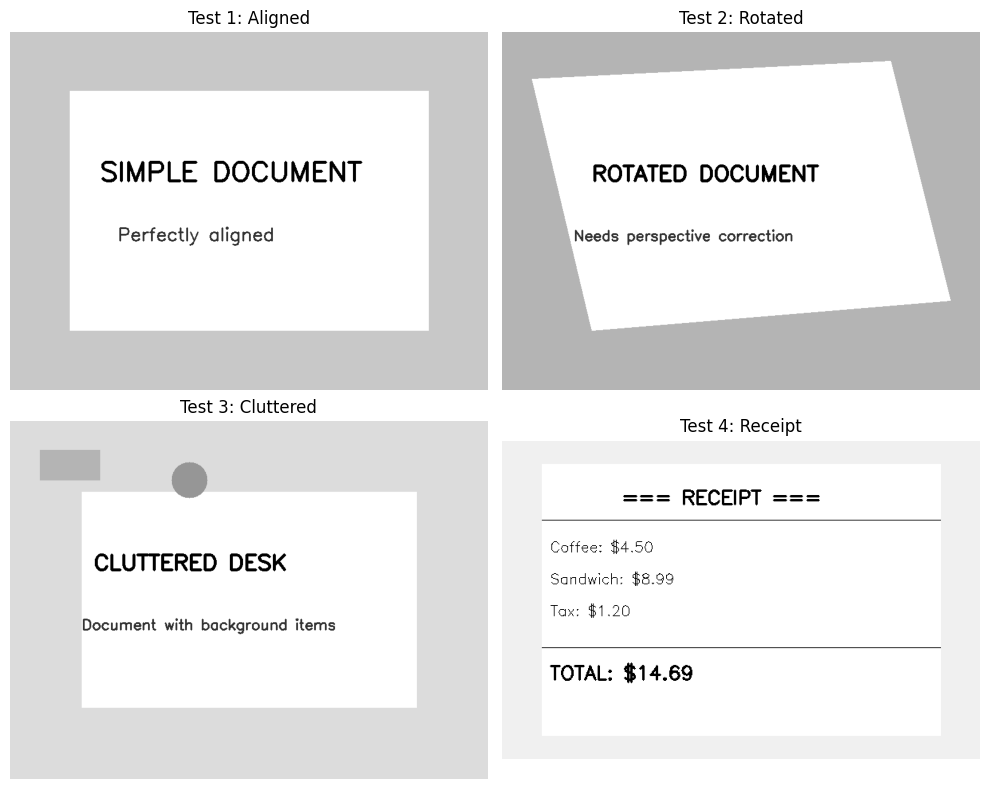


📤 Now test with: auto_crop_document('test_images/test2_rotated.jpg')


In [25]:
# ==============================================
# 🧪 6. CREATE TEST IMAGES
# ==============================================

def create_test_images():
    """Create sample document images for testing"""
    
    # Create test directory
    test_dir = Path("test_images")
    test_dir.mkdir(exist_ok=True)
    
    print("📸 Creating test images...")
    
    # Test 1: Simple aligned document
    img1 = np.ones((600, 800, 3), dtype=np.uint8) * 200  # Light gray background
    cv2.rectangle(img1, (100, 100), (700, 500), (255, 255, 255), -1)  # White document
    cv2.putText(img1, "SIMPLE DOCUMENT", (150, 250), 
                cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 0), 3)
    cv2.putText(img1, "Perfectly aligned", (180, 350), 
                cv2.FONT_HERSHEY_SIMPLEX, 1, (50, 50, 50), 2)
    path1 = test_dir / "test1_aligned.jpg"
    cv2.imwrite(str(path1), img1)
    
    # Test 2: Rotated document (perspective)
    img2 = np.ones((600, 800, 3), dtype=np.uint8) * 180
    pts = np.array([[50, 80], [650, 50], [750, 450], [150, 500]])
    cv2.fillPoly(img2, [pts], (255, 255, 255))
    cv2.putText(img2, "ROTATED DOCUMENT", (150, 250), 
                cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 0), 3)
    cv2.putText(img2, "Needs perspective correction", (120, 350), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (50, 50, 50), 2)
    path2 = test_dir / "test2_rotated.jpg"
    cv2.imwrite(str(path2), img2)
    
    # Test 3: Document on cluttered desk
    img3 = np.ones((600, 800, 3), dtype=np.uint8) * 220
    cv2.rectangle(img3, (120, 120), (680, 480), (255, 255, 255), -1)
    # Add some "clutter" (random objects)
    cv2.circle(img3, (300, 100), 30, (150, 150, 150), -1)  # Coffee cup
    cv2.rectangle(img3, (50, 50), (150, 100), (180, 180, 180), -1)  # Phone
    cv2.putText(img3, "CLUTTERED DESK", (140, 250), 
                cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 0), 3)
    cv2.putText(img3, "Document with background items", (120, 350), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (50, 50, 50), 2)
    path3 = test_dir / "test3_cluttered.jpg"
    cv2.imwrite(str(path3), img3)
    
    # Test 4: Small receipt-like document
    img4 = np.ones((400, 600, 3), dtype=np.uint8) * 240
    cv2.rectangle(img4, (50, 30), (550, 370), (255, 255, 255), -1)
    cv2.putText(img4, "=== RECEIPT ===", (150, 80), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 0), 2)
    cv2.line(img4, (50, 100), (550, 100), (0, 0, 0), 1)
    cv2.putText(img4, "Coffee: $4.50", (60, 140), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 1)
    cv2.putText(img4, "Sandwich: $8.99", (60, 180), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 1)
    cv2.putText(img4, "Tax: $1.20", (60, 220), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 1)
    cv2.line(img4, (50, 260), (550, 260), (0, 0, 0), 1)
    cv2.putText(img4, "TOTAL: $14.69", (60, 300), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 0), 2)
    path4 = test_dir / "test4_receipt.jpg"
    cv2.imwrite(str(path4), img4)
    
    print("✅ Created 4 test images:")
    for i, path in enumerate([path1, path2, path3, path4], 1):
        print(f"   {i}. {path.name}")
    
    # Display the test images
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.ravel()
    
    for i, (img, title) in enumerate(zip([img1, img2, img3, img4], 
                                        ["Aligned", "Rotated", "Cluttered", "Receipt"])):
        axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axes[i].set_title(f'Test {i+1}: {title}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("\n📤 Now test with: auto_crop_document('test_images/test2_rotated.jpg')")

# Create the test images
create_test_images()

🧪 TESTING AUTO-CROP FUNCTION
🔄 Processing: test_images/test2_rotated.jpg
✅ Loaded: test_images/test2_rotated.jpg (800x600)
📐 Original size: 800x600 pixels
✅ Found 1 contours
✅ Found quadrilateral contour (area: 255624)
✅ Document detected! Found 4 corner points
✅ Perspective correction applied: 606x435
📐 Cropped size: 606x435 pixels


C:\Users\Admin\AppData\Local\Temp\ipykernel_18712\71431575.py:44: UserWarning: Glyph 128247 (\N{CAMERA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_18712\71431575.py:44: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
d:\DocumentScanner\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128247 (\N{CAMERA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\DocumentScanner\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


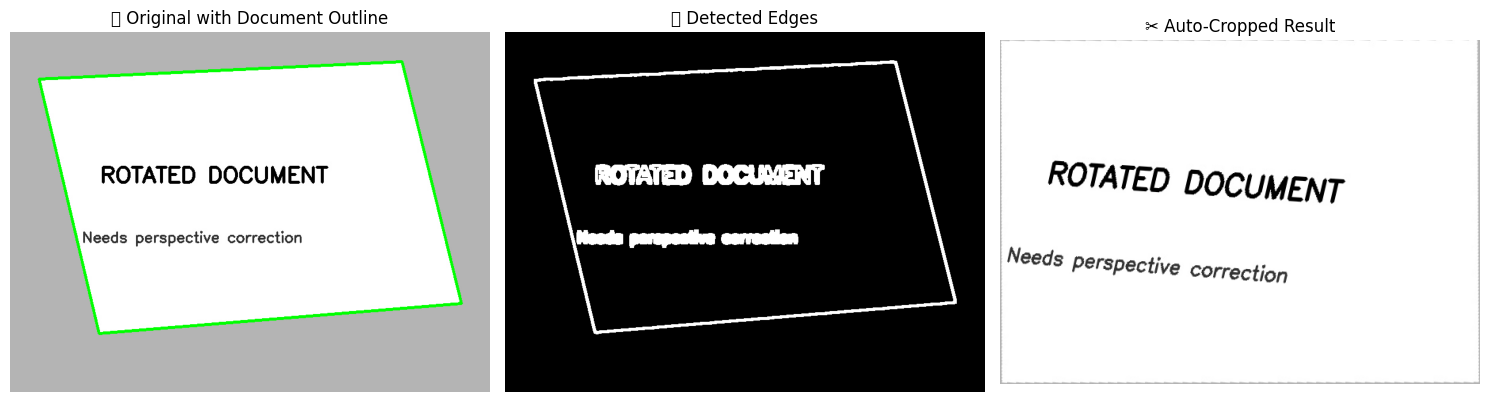

✅ Files saved successfully!
   Original: cropped_results\test2_rotated_original_1768031210.jpg
   Cropped: cropped_results\test2_rotated_cropped_1768031210.jpg
✅ Processing complete!
✅ Test successful!


In [26]:
# ==============================================
# ⚡ 7. TEST THE AUTO-CROP FUNCTION
# ==============================================

print("🧪 TESTING AUTO-CROP FUNCTION")
print("=" * 50)

# Test with the rotated document (most challenging)
test_result = auto_crop_document("test_images/test2_rotated.jpg")

if test_result:
    print("✅ Test successful!")
else:
    print("❌ Test failed!")

In [29]:
# ==============================================
# 📤 8. PROCESS YOUR OWN IMAGE
# ==============================================

def process_your_image():
    """Function to process your own uploaded image"""
    import tkinter as tk
    from tkinter import filedialog
    import os
    
    # Hide tkinter root window
    root = tk.Tk()
    root.withdraw()
    
    print("📤 Select your document image file...")
    
    # Open file dialog
    file_path = filedialog.askopenfilename(
        title="Select a document image",
        filetypes=[
            ("Image files", "*.jpg *.jpeg *.png *.bmp *.tiff"),
            ("All files", "*.*")
        ]
    )
    
    if not file_path:
        print("❌ No file selected")
        return
    
    print(f"✅ Selected: {file_path}")
    
    # Process the image
    auto_crop_document(file_path)

print("✅ Ready to process your own images!")
print("📤 To process your own image:")
print("   1. Run: process_your_image()")
print("   2. Select your image file")
print("   3. Wait for auto-cropping to complete")

✅ Ready to process your own images!
📤 To process your own image:
   1. Run: process_your_image()
   2. Select your image file
   3. Wait for auto-cropping to complete


📤 PROCESSING YOUR IMAGE
✅ File found: C:\Users\Admin\Downloads\WhatsApp Image 2024-07-21 at 10.03.38 AM.jpeg
🔄 Starting auto-crop...
🔄 Processing: C:\Users\Admin\Downloads\WhatsApp Image 2024-07-21 at 10.03.38 AM.jpeg
✅ Loaded: C:\Users\Admin\Downloads\WhatsApp Image 2024-07-21 at 10.03.38 AM.jpeg (1600x1200)
📐 Original size: 1600x1200 pixels
✅ Found 101 contours
⚠️ No perfect document found. Using bounding box.
✅ Document detected! Found 4 corner points
✅ Perspective correction applied: 1587x1026
📐 Cropped size: 1587x1026 pixels


C:\Users\Admin\AppData\Local\Temp\ipykernel_18712\71431575.py:44: UserWarning: Glyph 128247 (\N{CAMERA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_18712\71431575.py:44: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


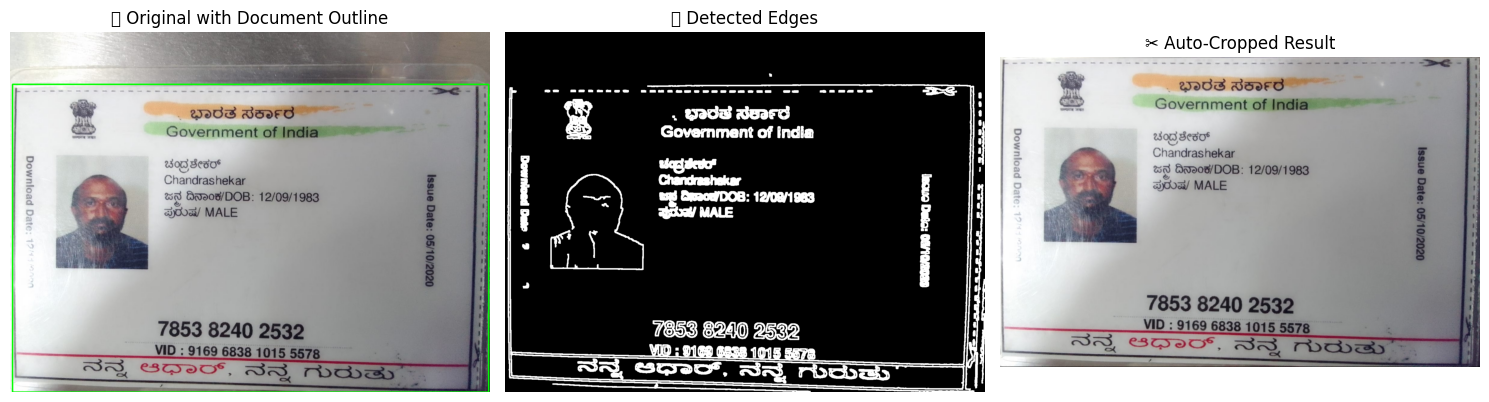

✅ Files saved successfully!
   Original: cropped_results\WhatsApp Image 2024-07-21 at 10.03.38 AM_original_1768031498.jpg
   Cropped: cropped_results\WhatsApp Image 2024-07-21 at 10.03.38 AM_cropped_1768031498.jpg
✅ Processing complete!
🎉 Your image has been auto-cropped successfully!


In [30]:
# ==============================================
# 📄 10. PROCESS YOUR SPECIFIC IMAGE
# ==============================================

print("=" * 50)
print("📤 PROCESSING YOUR IMAGE")
print("=" * 50)

# Your file path
your_image_path = r"C:\Users\Admin\Downloads\WhatsApp Image 2024-07-21 at 10.03.38 AM.jpeg"

# Check if file exists
import os
if os.path.exists(your_image_path):
    print(f"✅ File found: {your_image_path}")
    print("🔄 Starting auto-crop...")
    
    # Process your image
    result = auto_crop_document(your_image_path)
    
    if result:
        print("🎉 Your image has been auto-cropped successfully!")
    else:
        print("❌ Failed to process your image")
else:
    print(f"❌ File not found: {your_image_path}")
    print("Please check the file path and try again.")